In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gpytorch

from linear_operator.utils.cholesky import psd_safe_cholesky
from gpytorch.kernels import MaternKernel
from scipy.spatial import Delaunay
from scipy.interpolate import CubicSpline

np.random.seed(42)
torch.manual_seed(42)
global_dtype=torch.float64
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

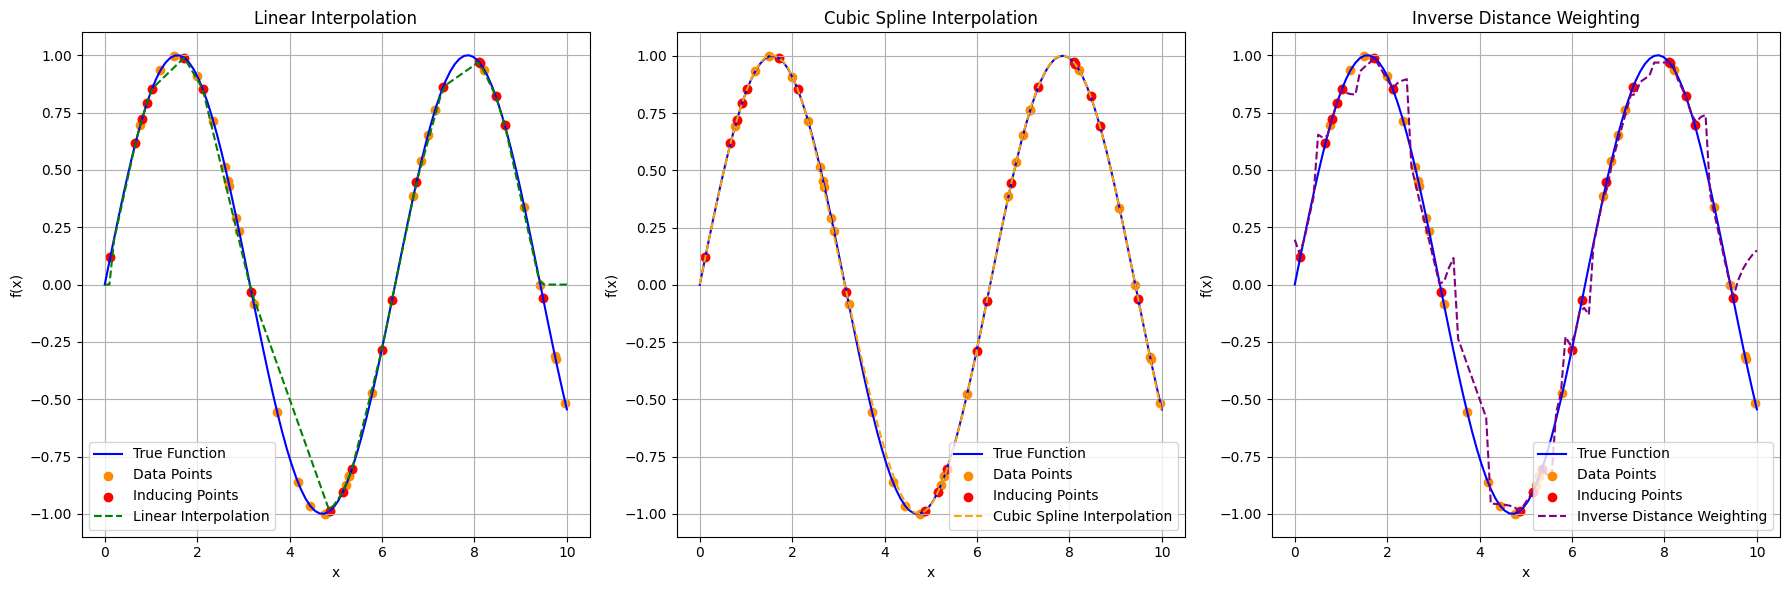

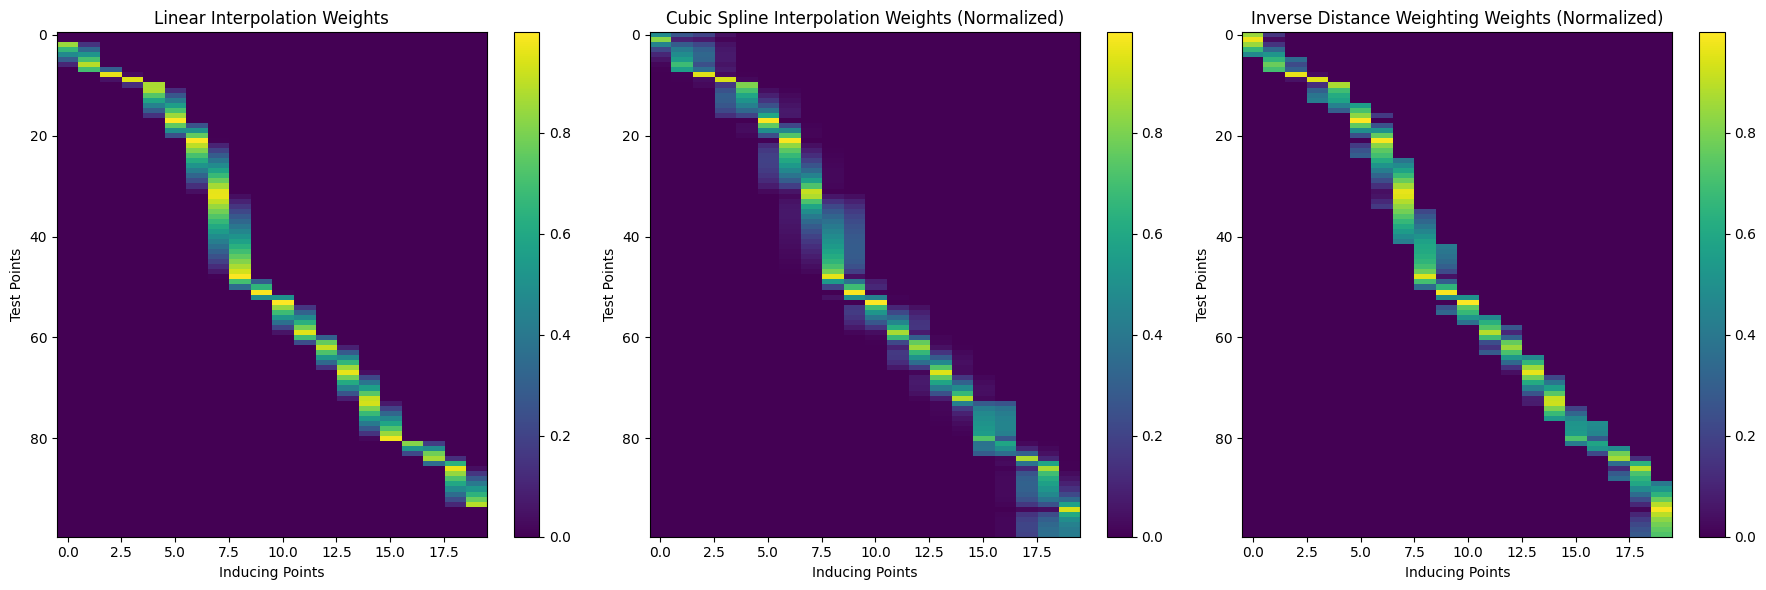

In [2]:

def true_function(x):
    return np.sin(x)

np.random.seed(80)
n_points = 50
data_points = np.sort(10 * np.random.rand(n_points))
data_values = true_function(data_points)

n_inducing = 20
inducing_indices = np.sort(np.random.choice(n_points, n_inducing, replace=False))
inducing_points = data_points[inducing_indices]
inducing_values = data_values[inducing_indices]

test_points = np.linspace(0, 10, 100)
true_test_values = true_function(test_points)

def linear_interpolation_weights(x, z):
    W = np.zeros((len(x), len(z)))
    for i, xi in enumerate(x):
        z_a_idx = np.searchsorted(z, xi) - 1
        z_b_idx = np.searchsorted(z, xi)
        if z_a_idx < 0:
            z_a_idx = 0
        if z_b_idx >= len(z):
            z_b_idx = len(z) - 1
        z_a = z[z_a_idx]
        z_b = z[z_b_idx]
        if z_b != z_a:
            w_i = (xi - z_a) / (z_b - z_a)
        else:
            w_i = 0
        W[i, z_a_idx] = 1 - w_i
        W[i, z_b_idx] = w_i
    return W

def cubic_interpolation_weights(x, z):
    W = np.zeros((len(x), len(z)))
    for i, xi in enumerate(x):
        idx = np.searchsorted(z, xi) - 2
        idx = np.clip(idx, 0, len(z) - 4)
        neighbors = np.arange(idx, idx + 4)
        neighbors = np.clip(neighbors, 0, len(z) - 1)
        if len(neighbors) < 4:
            continue
        cs = CubicSpline(z[neighbors], np.eye(4), bc_type='natural')
        weights = cs(xi)
        W[i, neighbors] = weights
    return W

def inverse_distance_weighting_weights(x, z):
    W = np.zeros((len(x), len(z)))
    for i, xi in enumerate(x):
        distances = np.abs(z - xi)
        nearest_indices = np.argsort(distances)[:2]
        weights = 1 / distances[nearest_indices]
        weights /= weights.sum()
        W[i, nearest_indices] = weights
    return W

W_linear = linear_interpolation_weights(test_points, inducing_points)
W_cubic = cubic_interpolation_weights(test_points, inducing_points)
W_idw = inverse_distance_weighting_weights(test_points, inducing_points)

def interpolate_values(W, fz):
    return np.dot(W, fz)

linear_interpolated_values = interpolate_values(W_linear, inducing_values)
cubic_interpolated_values = interpolate_values(W_cubic, inducing_values)
idw_interpolated_values = interpolate_values(W_idw, inducing_values)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(test_points, true_test_values, label='True Function', color='blue')
axs[0].scatter(data_points, data_values, color='darkorange', label='Data Points')
axs[0].scatter(inducing_points, inducing_values, color='red', label='Inducing Points')
axs[0].plot(test_points, linear_interpolated_values, label='Linear Interpolation', linestyle='--', color='green')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_title('Linear Interpolation')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(test_points, true_test_values, label='True Function', color='blue')
axs[1].scatter(data_points, data_values, color='darkorange', label='Data Points')
axs[1].scatter(inducing_points, inducing_values, color='red', label='Inducing Points')
axs[1].plot(test_points, cubic_interpolated_values, label='Cubic Spline Interpolation', linestyle='--', color='orange')
axs[1].set_xlabel('x')
axs[1].set_ylabel('f(x)')
axs[1].set_title('Cubic Spline Interpolation')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(test_points, true_test_values, label='True Function', color='blue')
axs[2].scatter(data_points, data_values, color='darkorange', label='Data Points')
axs[2].scatter(inducing_points, inducing_values, color='red', label='Inducing Points')
axs[2].plot(test_points, idw_interpolated_values, label='Inverse Distance Weighting', linestyle='--', color='purple')
axs[2].set_xlabel('x')
axs[2].set_ylabel('f(x)')
axs[2].set_title('Inverse Distance Weighting')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

W_cubic_normalized = np.abs(W_cubic)
row_sums_cubic = W_cubic_normalized.sum(axis=1)
W_cubic_normalized = W_cubic_normalized / row_sums_cubic[:, np.newaxis]

W_idw_normalized = np.abs(W_idw)
row_sums_idw = W_idw_normalized.sum(axis=1)
W_idw_normalized = W_idw_normalized / row_sums_idw[:, np.newaxis]

min_val = min(W_linear.min(), W_cubic_normalized.min(), W_idw_normalized.min())
max_val = max(W_linear.max(), W_cubic_normalized.max(), W_idw_normalized.max())

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
cmap = 'viridis'

im0 = axs[0].imshow(W_linear, aspect='auto', cmap=cmap, vmin=min_val, vmax=max_val)
axs[0].set_title('Linear Interpolation Weights')
axs[0].set_xlabel('Inducing Points')
axs[0].set_ylabel('Test Points')

im1 = axs[1].imshow(W_cubic_normalized, aspect='auto', cmap=cmap, vmin=min_val, vmax=max_val)
axs[1].set_title('Cubic Spline Interpolation Weights (Normalized)')
axs[1].set_xlabel('Inducing Points')
axs[1].set_ylabel('Test Points')

im2 = axs[2].imshow(W_idw_normalized, aspect='auto', cmap=cmap, vmin=min_val, vmax=max_val)
axs[2].set_title('Inverse Distance Weighting Weights (Normalized)')
axs[2].set_xlabel('Inducing Points')
axs[2].set_ylabel('Test Points')

fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


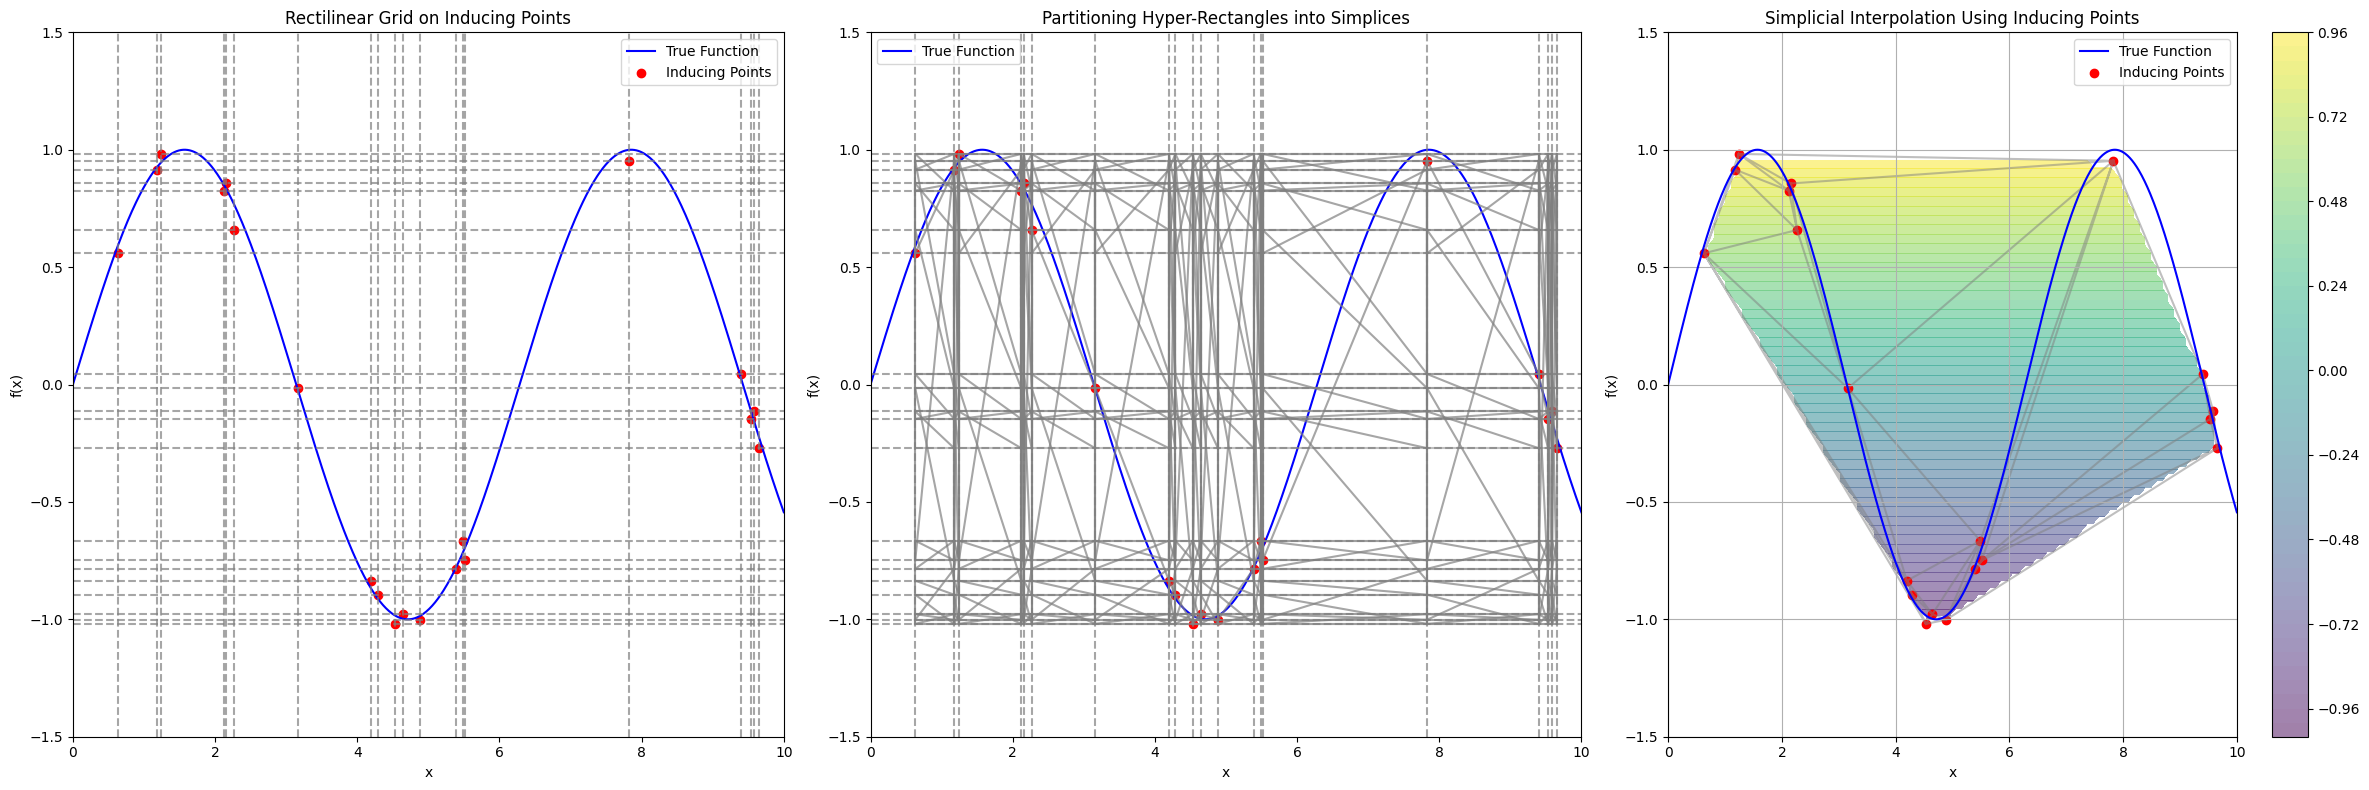

In [3]:
def true_function(x):
    return np.sin(x)

n_points = 100
x_data = np.sort(10 * np.random.rand(n_points))
y_data = true_function(x_data) + 0.05 * np.random.randn(n_points)

n_inducing = 20
inducing_indices = np.sort(np.random.choice(n_points, n_inducing, replace=False))
x_inducing = x_data[inducing_indices]
y_inducing = y_data[inducing_indices]

inducing_points = np.vstack((x_inducing, y_inducing)).T

tri = Delaunay(inducing_points)

def simplicial_interpolation(point, tri, values):
    simplex = tri.find_simplex(point)
    if simplex == -1:
        return np.nan
    vertices = tri.simplices[simplex]
    bary_coords = np.append(tri.transform[simplex, :2].dot(point - tri.transform[simplex, 2]), 1 - np.sum(tri.transform[simplex, :2].dot(point - tri.transform[simplex, 2])))
    return np.dot(bary_coords, values[vertices])

x_grid = np.linspace(0, 10, 100)
y_grid = np.linspace(-1.5, 1.5, 100)
xv, yv = np.meshgrid(x_grid, y_grid)
interp_points = np.vstack([xv.ravel(), yv.ravel()]).T

interp_values = np.array([simplicial_interpolation(p, tri, y_inducing) for p in interp_points])
interp_values = interp_values.reshape(xv.shape)

x_true = np.linspace(0, 10, 1000)
y_true = true_function(x_true)

fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[0].plot(x_true, y_true, label='True Function', color='blue')
axs[0].scatter(x_inducing, y_inducing, color='red', label='Inducing Points')

x_rect_grid = np.unique(x_inducing)
y_rect_grid = np.unique(y_inducing)
for xi in x_rect_grid:
    axs[0].axvline(x=xi, color='gray', linestyle='--', alpha=0.7)
for yi in y_rect_grid:
    axs[0].axhline(y=yi, color='gray', linestyle='--', alpha=0.7)

axs[0].set_xlim(0, 10)
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_title('Rectilinear Grid on Inducing Points')
axs[0].legend()

axs[1].plot(x_true, y_true, label='True Function', color='blue')
for xi in x_rect_grid:
    axs[1].axvline(x=xi, color='gray', linestyle='--', alpha=0.7)
for yi in y_rect_grid:
    axs[1].axhline(y=yi, color='gray', linestyle='--', alpha=0.7)

for i in range(len(x_inducing) - 1):
    for j in range(len(y_inducing) - 1):
        vertices = np.array([
            [x_inducing[i], y_inducing[j]],
            [x_inducing[i + 1], y_inducing[j]],
            [x_inducing[i], y_inducing[j + 1]],
            [x_inducing[i + 1], y_inducing[j + 1]]
        ])
        axs[1].plot(vertices[[0, 1, 3, 2, 0], 0], vertices[[0, 1, 3, 2, 0], 1], 'gray', alpha=0.5)
        axs[1].plot(vertices[[0, 3], 0], vertices[[0, 3], 1], 'gray', alpha=0.7)

axs[1].scatter(x_inducing, y_inducing, color='red')
axs[1].set_xlim(0, 10)
axs[1].set_ylim(-1.5, 1.5)
axs[1].set_xlabel('x')
axs[1].set_ylabel('f(x)')
axs[1].set_title('Partitioning Hyper-Rectangles into Simplices')
axs[1].legend()

axs[2].plot(x_true, y_true, label='True Function', color='blue')
contour = axs[2].contourf(xv, yv, interp_values, levels=50, cmap='viridis', alpha=0.5)
fig.colorbar(contour, ax=axs[2])
axs[2].scatter(x_inducing, y_inducing, color='red', label='Inducing Points')
axs[2].triplot(inducing_points[:, 0], inducing_points[:, 1], tri.simplices, color='gray', alpha=0.5)
axs[2].set_xlim(0, 10)
axs[2].set_ylim(-1.5, 1.5)
axs[2].set_xlabel('x')
axs[2].set_ylabel('f(x)')
axs[2].set_title('Simplicial Interpolation Using Inducing Points')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


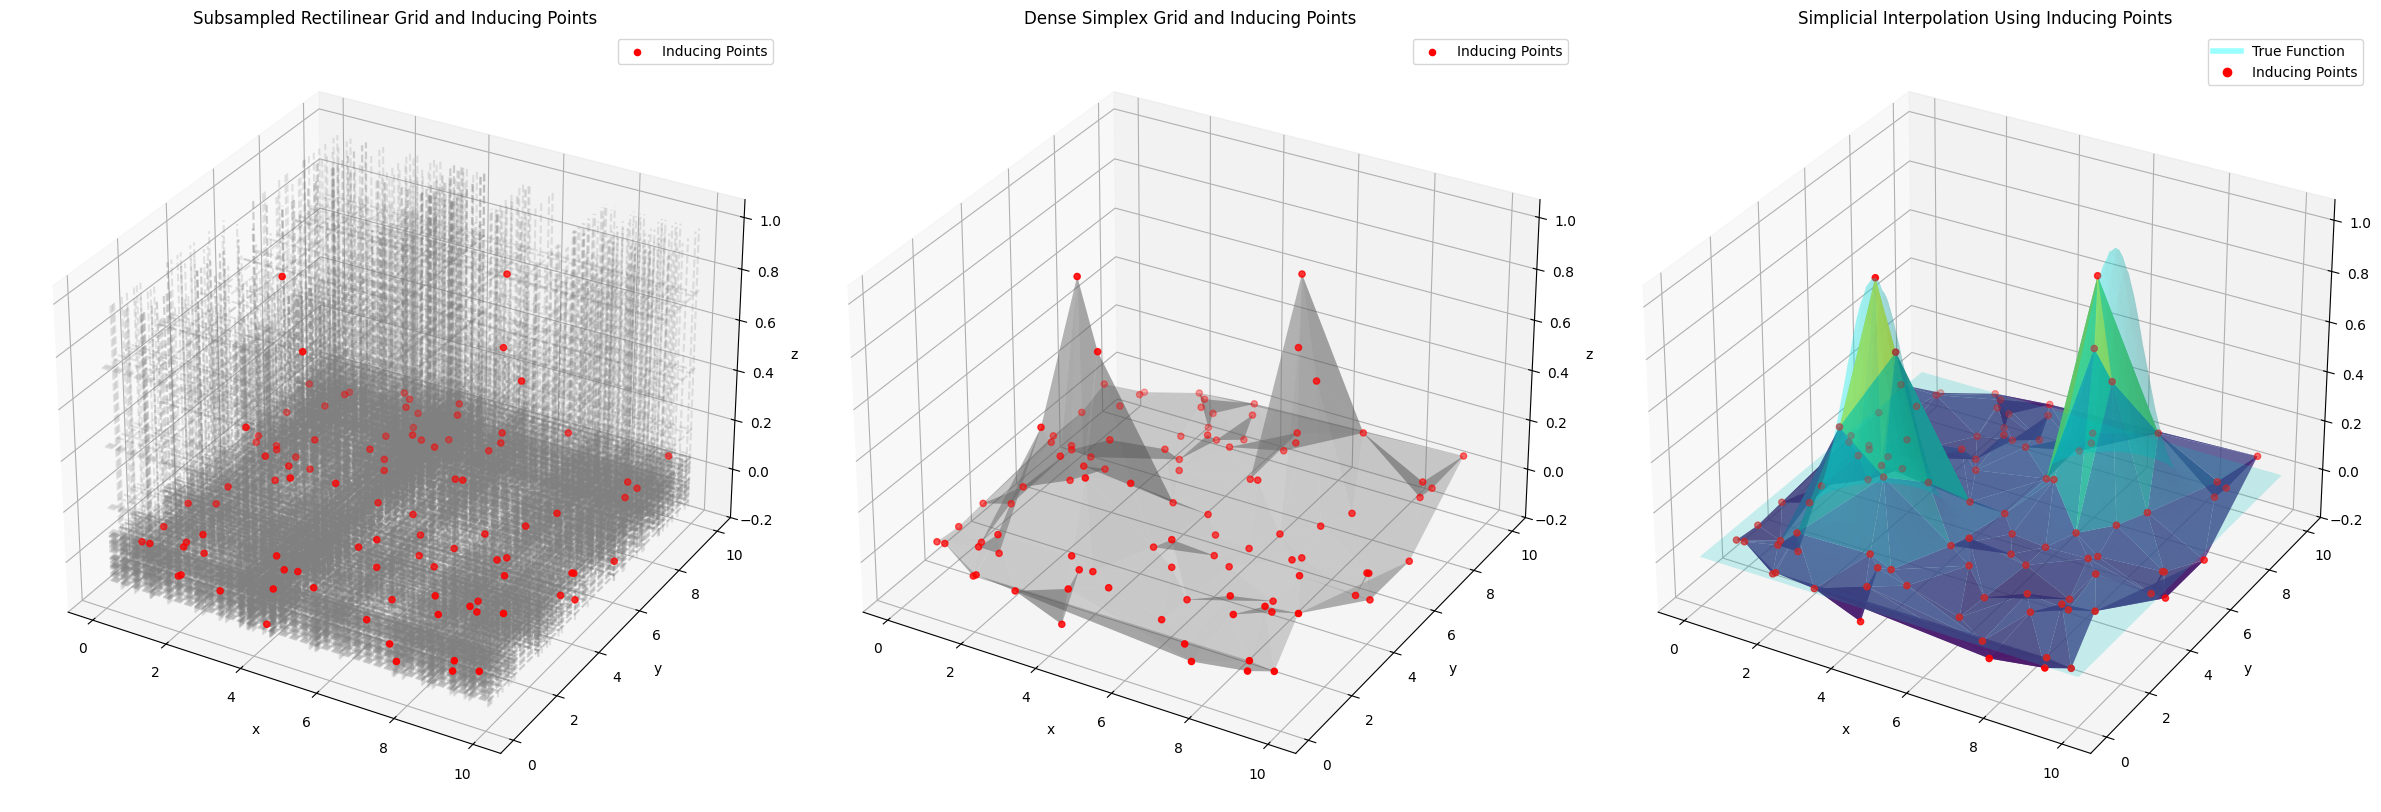

In [4]:
def true_function_3d(x, y):
    return np.exp(-((x-3)**2 + (y-3)**2)) + np.exp(-((x-7)**2 + (y-7)**2))

n_points = 500
x_data = 10 * np.random.rand(n_points)
y_data = 10 * np.random.rand(n_points)
z_data = true_function_3d(x_data, y_data) + 0.05 * np.random.randn(n_points)

n_inducing = 100
inducing_indices = np.sort(np.random.choice(n_points, n_inducing, replace=False))
x_inducing = x_data[inducing_indices]
y_inducing = y_data[inducing_indices]
z_inducing = z_data[inducing_indices]

inducing_points = np.vstack((x_inducing, y_inducing, z_inducing)).T

tri = Delaunay(inducing_points[:, :2])

def simplicial_interpolation_3d(point, tri, values):
    simplex = tri.find_simplex(point[:2])
    if simplex == -1:
        return np.nan
    vertices = tri.simplices[simplex]
    bary_coords = np.append(tri.transform[simplex, :2].dot(point[:2] - tri.transform[simplex, 2]), 1 - np.sum(tri.transform[simplex, :2].dot(point[:2] - tri.transform[simplex, 2])))
    return np.dot(bary_coords, values[vertices])

x_grid = np.linspace(0, 10, 30)
y_grid = np.linspace(0, 10, 30)
z_grid = np.linspace(-1.5, 1.5, 30)
xv, yv, zv = np.meshgrid(x_grid, y_grid, z_grid)
interp_points = np.vstack([xv.ravel(), yv.ravel(), zv.ravel()]).T

interp_values = np.array([simplicial_interpolation_3d(np.array([p[0], p[1], 0]), tri, z_inducing) for p in interp_points])
interp_values = interp_values.reshape(xv.shape)

x_true = np.linspace(0, 10, 100)
y_true = np.linspace(0, 10, 100)
xv_true, yv_true = np.meshgrid(x_true, y_true)
z_true = true_function_3d(xv_true, yv_true)

x_min, x_max = np.min(x_inducing), np.max(x_inducing)
y_min, y_max = np.min(y_inducing), np.max(y_inducing)
z_min, z_max = np.min(z_inducing), np.max(z_inducing)

def plot_rectilinear_grid(ax, x_vals, y_vals, z_vals, subsample=5, color='gray', linestyle='--', alpha=0.2):
    x_vals_subsampled = x_vals[::subsample]
    y_vals_subsampled = y_vals[::subsample]
    z_vals_subsampled = z_vals[::subsample]

    for x in x_vals_subsampled:
        for y in y_vals_subsampled:
            ax.plot([x, x], [y, y], [z_min, z_max], color=color, linestyle=linestyle, alpha=alpha)
    for y in y_vals_subsampled:
        for z in z_vals_subsampled:
            ax.plot([x_min, x_max], [y, y], [z, z], color=color, linestyle=linestyle, alpha=alpha)
    for x in x_vals_subsampled:
        for z in z_vals_subsampled:
            ax.plot([x, x], [y_min, y_max], [z, z], color=color, linestyle=linestyle, alpha=alpha)

fig = plt.figure(figsize=(24, 8))

ax1 = fig.add_subplot(131, projection='3d')
plot_rectilinear_grid(ax1, x_inducing, y_inducing, z_inducing, subsample=3)
ax1.scatter(x_inducing, y_inducing, z_inducing, color='red', label='Inducing Points')
ax1.set_title('Subsampled Rectilinear Grid and Inducing Points')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.legend()

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_trisurf(inducing_points[:, 0], inducing_points[:, 1], inducing_points[:, 2], triangles=tri.simplices, color='gray', alpha=0.3)
ax2.scatter(x_inducing, y_inducing, z_inducing, color='red', label='Inducing Points')
ax2.set_title('Dense Simplex Grid and Inducing Points')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.legend()

ax3 = fig.add_subplot(133, projection='3d')
surface = ax3.plot_surface(xv_true, yv_true, z_true, color='cyan', alpha=0.2, label='True Function')
trisurf = ax3.plot_trisurf(inducing_points[:, 0], inducing_points[:, 1], inducing_points[:, 2], triangles=tri.simplices, cmap='viridis', alpha=0.8, label='Interpolated Surface')
ax3.scatter(x_inducing, y_inducing, z_inducing, color='red', label='Inducing Points')
ax3.set_title('Simplicial Interpolation Using Inducing Points')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

custom_lines = [plt.Line2D([0], [0], color='cyan', lw=4, alpha=0.4),
                plt.Line2D([0], [0], color='red', marker='o', linestyle='None'),
                plt.Line2D([0], [0], color='purple', lw=4)]
ax3.legend(custom_lines, ['True Function', 'Inducing Points'])

plt.tight_layout()
plt.show()
